# Imports

In [1]:
import time

import torch
import torch.nn as nn
from torch.nn import Sequential
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2 as cv

from src.constants import (
    COLLAPSED_ANNOTATIONS_PATH,
    POSITIVES_PATH,
    POSITIVES_VALIDATION_PATH,
    VALIDATION_ANNOTATIONS_PATH,
    MODEL_PATH,
    LABELS_MAP,
)
from src.utils.readers import get_images, get_annotations

from src.utils.helpers import check_if_dirs_exist

# Constants

In [2]:
from pathlib import Path

MODEL_PATH = Path("../" + str(MODEL_PATH))
POSITIVES_PATH = Path("../" + str(POSITIVES_PATH))
POSITIVES_VALIDATION_PATH = Path("../" + str(POSITIVES_VALIDATION_PATH))
COLLAPSED_ANNOTATIONS_PATH = Path("../" + str(COLLAPSED_ANNOTATIONS_PATH))
VALIDATION_ANNOTATIONS_PATH = Path("../" + str(VALIDATION_ANNOTATIONS_PATH))

INIT_LR = 1e-4
BATCH_SIZE = 64
EPOCHS = 100

# Initializations

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading

In [4]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        label = torch.tensor(LABELS_MAP[label], dtype=torch.long)
        image = self.transform(image)

        return image, label

In [5]:
trainImages = get_images(POSITIVES_PATH)
trainImages = [cv.cvtColor(image, cv.COLOR_BGR2RGB) for image in trainImages]
trainAnnotations = get_annotations(COLLAPSED_ANNOTATIONS_PATH)
trainLabels = []

valImages = get_images(POSITIVES_VALIDATION_PATH)
valImages = [cv.cvtColor(image, cv.COLOR_BGR2RGB) for image in valImages]
valAnnotations = get_annotations(VALIDATION_ANNOTATIONS_PATH)
valLabels = []

for image_name, detections_list in trainAnnotations.items():
    for _, char in detections_list:
        trainLabels.append(char)
        trainLabels.append(char)

for image_name, detections_list in valAnnotations.items():
    for _, char in detections_list:
        valLabels.append(char)
        valLabels.append(char)

trainDataset = CustomDataset(trainImages, trainLabels)
valDataset = CustomDataset(valImages, valLabels)

trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=True)

print("[INFO] number of training images: {}".format(len(trainImages)))
print("[INFO] number of training labels: {}".format(len(trainLabels)))
print("[INFO] number of validation images: {}".format(len(valImages)))
print("[INFO] number of validation labels: {}".format(len(valLabels)))

[INFO] number of training images: 13952
[INFO] number of training labels: 13952
[INFO] number of validation images: 644
[INFO] number of validation labels: 644


# Visualize data

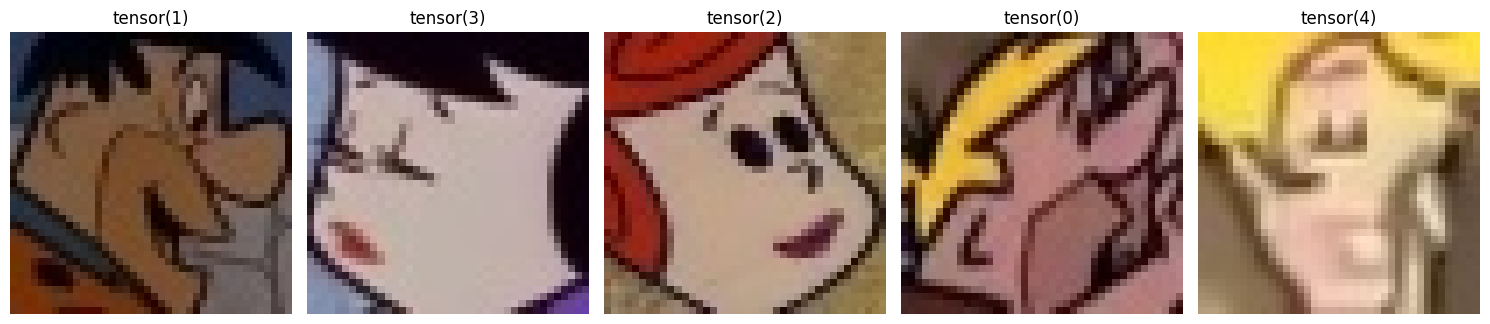

In [6]:
found = set()  # Using a set to store unique labels found
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # Creating subplots for 5 images

for images, labels in trainDataLoader:
    for image, label in zip(images, labels):
        if label.item() not in found:
            found.add(label.item())
            image = image.permute(1, 2, 0).numpy()

            # Plot the image in the next available subplot
            ax = axes[len(found) - 1]
            ax.imshow(image)
            ax.set_title(label)
            ax.axis("off")

        if len(found) == 5:
            break
    if len(found) == 5:
        break

# Show the subplots
plt.tight_layout()
plt.show()

# Data frequency

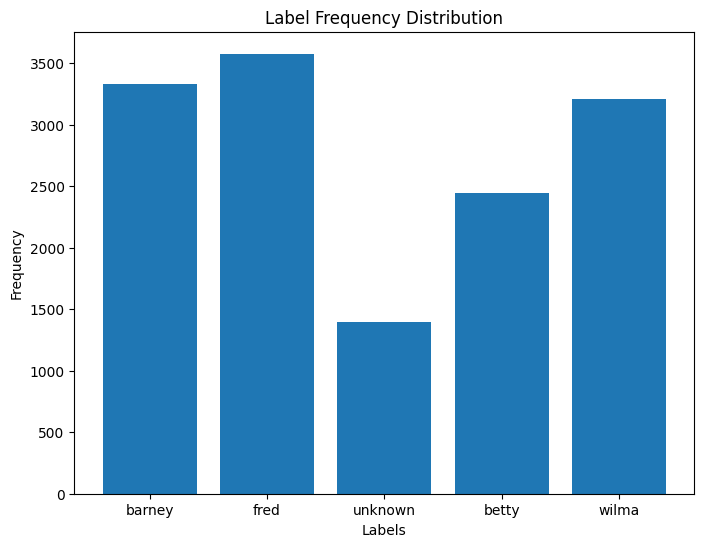

In [7]:
from collections import Counter

# Choose between trainLabels or valLabels
labels = trainLabels  # Change this to valLabels for validation dataset

# Count occurrences of each label
label_counts = Counter(labels)

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Label Frequency Distribution")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.show()

# Model

In [8]:
model = Sequential(
    # Input: 3x40x40
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Dropout(0.25),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256, 5),
    nn.Softmax(1),
).to(device)

# Optimizer and loss function

In [9]:
optimizer = Adam(model.parameters(), lr=INIT_LR)
loss_function = nn.CrossEntropyLoss()

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

# Training

In [10]:
print("[INFO] training the network...")
startTime = time.time()

for e in range(EPOCHS):
    model.train()
    totalTrainLoss = 0
    trainCorrect = 0

    for x, y in trainDataLoader:
        optimizer.zero_grad()
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = loss_function(pred, y)
        loss.backward()
        optimizer.step()
        totalTrainLoss += loss.item()

        pred = torch.argmax(pred, dim=1)
        trainCorrect += (pred == y).sum().item()

    avgTrainLoss = totalTrainLoss / trainSteps
    trainAccuracy = trainCorrect / len(trainDataLoader.dataset)

    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainAccuracy))

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/100
Train loss: 1.574709, Train accuracy: 0.2752
[INFO] EPOCH: 2/100
Train loss: 1.306134, Train accuracy: 0.6204
[INFO] EPOCH: 3/100
Train loss: 1.143342, Train accuracy: 0.7754
[INFO] EPOCH: 4/100
Train loss: 1.105294, Train accuracy: 0.8073
[INFO] EPOCH: 5/100
Train loss: 1.081589, Train accuracy: 0.8278
[INFO] EPOCH: 6/100
Train loss: 1.070765, Train accuracy: 0.8397
[INFO] EPOCH: 7/100
Train loss: 1.061597, Train accuracy: 0.8453
[INFO] EPOCH: 8/100
Train loss: 1.051479, Train accuracy: 0.8568
[INFO] EPOCH: 9/100
Train loss: 1.043780, Train accuracy: 0.8643
[INFO] EPOCH: 10/100
Train loss: 1.039532, Train accuracy: 0.8687
[INFO] EPOCH: 11/100
Train loss: 1.037218, Train accuracy: 0.8701
[INFO] EPOCH: 12/100
Train loss: 1.032314, Train accuracy: 0.8756
[INFO] EPOCH: 13/100
Train loss: 1.027530, Train accuracy: 0.8787
[INFO] EPOCH: 14/100
Train loss: 1.025762, Train accuracy: 0.8802
[INFO] EPOCH: 15/100
Train loss: 1.023928, Train accur

# Test the model on validation data

In [11]:
model.eval()
valCorrect = 0

with torch.no_grad():
    for x, y in valDataLoader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        pred = torch.argmax(pred, dim=1)
        valCorrect += (pred == y).sum().item()

valAccuracy = valCorrect / len(valDataLoader.dataset)

print("Validation accuracy: {:.4f}".format(valAccuracy))

Validation accuracy: 0.9752


# Saving the model

In [12]:
check_if_dirs_exist([MODEL_PATH])
model_scripted = torch.jit.script(model)
model_scripted.save(str(MODEL_PATH / "task2_cnn.pth"))